In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargue de la base de datos completa de PQR
root = Path("/content/drive/MyDrive/Analitica")

df = pd.read_csv(
    root / "pqr_medicamentos.csv",
    sep=";",
    engine="python"
)

df.head()

,OID_,A¥O,MES,PQR_CANAL,PET_COD_DEPTO,PET_COD_MPIO,ID_AFEC,AFEC_PARENTESCO,AFEC_GENERO,AFEC_EDADR,AFEC_EDUC,AFEC_REGAFILIACION,AFEC_GETNICO,AFEC_POBESPECIAL,AFEC_COD_DEPTO,AFEC_COD_MPIO,ENT_NOMBRE,ENT_TIPOVIG_SNS,ENT_COD_SNS,ENT_ALIAS_SNS,ENT_COD_DEPTO,ENT_COD_MPIO,COD_MACROMOT,MACROMOTIVO,COD_MOTGEN,MOTIVO_GENERAL,COD_MOTESP,MOTIVO_ESPECIFICO,PATOLOGIA_1,PATOLOGIA_TIPO,CIE_10,RIESGO_VIDA,ALTO_COSTO
0,4,2021,1,Telefonico,68.0,68276.0,US- 000001949695,Otro,Hombre,DE 50 A 62,Primaria,Contributivo,No Aplica,No Aplica,68.0,68001.0,SALUD TOTAL,REGIMEN CONTRIBUTIVO,EPS002,SALUD TOTAL,68,68001,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10302,DEMORA DE LA AUTORIZACION DE MEDICAMENTOS NO-POS,ENFERMEDADES CRONICAS NO TRANSMISIBLES RENALES,"IRC, ENFERMEDAD RENAL",ENFERMEDAD RENAL CRONICA,SI,DIALISIS PERITONEAL
1,13,2021,7,Telefonico,68.0,68276.0,US- 000001949698,Hijo (A),Hombre,MAYOR DE 63,Primaria Incompleta,Regimen Especial,No Aplica,No Aplica,68.0,68276.0,MAGISTERIO,REGIMENES DE EXCEPCION Y ESPECIALES,REMG01,MAGISTERIO,68,68276,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1010,RESTRICCION EN EL ACCESO POR FALTA DE OPORTUNI...,10119,FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAME...,ENFERMEDADES CRONICAS NO TRASMISIBLES CARDIOVA...,HTA (HIPERTENSION ARTERIAL),"DOLOR EN EL PECHO, NO ESPECIFICADO",SI,NO APLICA
2,15,2021,2,Personalizado,63.0,63130.0,US- 000000931064,Nombre Propio,Hombre,DE 50 A 62,Primaria,Contributivo,No Aplica,No Aplica,63.0,63130.0,NUEVA EPS,REGIMEN SUBSIDIADO,EPSS41,NUEVA EPS,63,63001,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1040,RESTRICCION EN EL ACCESO POR NEGACION DE LA AU...,10402,NEGACION DE LA AUTORIZACION DE MEDICAMENTOS NO...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,CARDIOMIOPATIA ISQUMICA,SI,NO APLICA
3,34,2021,9,Telefonico,68.0,68001.0,US- 000001039632,Otro,Mujer,MAYOR DE 63,Universitario Incompleto,Contributivo,No Aplica,No Aplica,68.0,68001.0,SALUD TOTAL,REGIMEN CONTRIBUTIVO,EPS002,SALUD TOTAL,68,68001,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10301,DEMORA DE LA AUTORIZACION DE MEDICAMENTOS POS,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,"OTRAS OSTEOPOROSIS, CON FRACTURA PATOLOGICA",NO,NO APLICA
4,66,2021,4,Web,76.0,76147.0,US- 000001066882,Nombre Propio,Mujer,DE 50 A 62,No Aplica,Subsidiado,No Aplica,No Aplica,76.0,76147.0,BARRIOS UNIDOS DE QUIBDO -AMBUQ,REGIMEN SUBSIDIADO,ESS076,AMBUQ (BARRIOS UNDOS DE QUIBDO),76,76147,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1010,RESTRICCION EN EL ACCESO POR FALTA DE OPORTUNI...,10119,FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAME...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,EMBOLIA Y TROMBOSIS DE VENA NO ESPECIFICADA,NO,NO APLICA


In [ ]:
#Corrección de la codificación
for col in df.select_dtypes(include="object").columns:
    df[col] = (
        df[col]
        .str.encode("latin1", errors="ignore")
        .str.decode("utf-8", errors="ignore")
    )

In [ ]:
#Validación de los datos
print(df.head())
print(df.shape)

   OID_   A¥O  ...  RIESGO_VIDA           ALTO_COSTO
0     4  2021  ...           SI  DIALISIS PERITONEAL
1    13  2021  ...           SI            NO APLICA
2    15  2021  ...           SI            NO APLICA
3    34  2021  ...           NO            NO APLICA
4    66  2021  ...           NO            NO APLICA

[5 rows x 33 columns]
(328987, 33)


In [ ]:
#Se realizó la estandarización de los nombres de las variables, corrigiendo problemas de codificación y adoptando nombres descriptivos y consistentes.
df = df.rename(columns={
    "oid_": "id_registro",
    "a¥o": "anio",
    "mes": "mes",
    "pqr_canal": "canal_pqr",
    "pet_cod_depto": "cod_depto_peticion",
    "pet_cod_mpio": "cod_mpio_peticion",
    "id_afec": "id_afectado",
    "afec_parentesco": "parentesco_afectado",
    "afec_genero": "genero_afectado",
    "afec_edadr": "rango_edad_afectado",
    "afec_educ": "nivel_educativo_afectado",
    "afec_regafiliacion": "regimen_afiliacion_afectado",
    "afec_getnico": "grupo_etnico_afectado",
    "afec_pobespecial": "poblacion_especial_afectado",
    "afec_cod_depto": "cod_depto_afectado",
    "afec_cod_mpio": "cod_mpio_afectado",
    "ent_nombre": "nombre_entidad",
    "ent_tipovig_sns": "tipo_vigencia_sns",
    "ent_cod_sns": "codigo_sns_entidad",
    "ent_alias_sns": "alias_entidad"
})


In [ ]:
#Convertir los nombres de las columnas a minúscula y reemplazar los espacios por guión bajo
df.columns = df.columns.str.lower().str.replace(" ", "_")

In [ ]:
#Validar nombre de las columnas
df.columns

Index(['id_registro', 'anio', 'mes', 'canal_pqr', 'cod_depto_peticion',
       'cod_mpio_peticion', 'id_afectado', 'parentesco_afectado',
       'genero_afectado', 'rango_edad_afectado', 'nivel_educativo_afectado',
       'regimen_afiliacion_afectado', 'grupo_etnico_afectado',
       'poblacion_especial_afectado', 'cod_depto_afectado',
       'cod_mpio_afectado', 'nombre_entidad', 'tipo_vigencia_sns',
       'codigo_sns_entidad', 'alias_entidad', 'ent_cod_depto', 'ent_cod_mpio',
       'cod_macromot', 'macromotivo', 'cod_motgen', 'motivo_general',
       'cod_motesp', 'motivo_especifico', 'patologia_1', 'patologia_tipo',
       'cie_10', 'riesgo_vida', 'alto_costo'],
      dtype='object')

Se realiza la limpieza de los datos, eliminando las columnas que no son necesarias y agregando una categoría para los datos faltantes

In [ ]:
#Filtrar la base solamente por el departamento de Cundinamarca
df_cundinamarca = df[df["cod_depto_peticion"] == 25]


In [ ]:
#Información de la base seleccionada
df_cundinamarca.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12173 entries, 13 to 328931
Data columns (total 33 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id_registro                  12173 non-null  int64  
 1   anio                         12173 non-null  int64  
 2   mes                          12173 non-null  int64  
 3   canal_pqr                    12173 non-null  object 
 4   cod_depto_peticion           12173 non-null  float64
 5   cod_mpio_peticion            12173 non-null  float64
 6   id_afectado                  12173 non-null  object 
 7   parentesco_afectado          12173 non-null  object 
 8   genero_afectado              12173 non-null  object 
 9   rango_edad_afectado          12173 non-null  object 
 10  nivel_educativo_afectado     12173 non-null  object 
 11  regimen_afiliacion_afectado  12173 non-null  object 
 12  grupo_etnico_afectado        12173 non-null  object 
 13  poblacion_especial_

In [ ]:
#Cantidad de filas y columnas
df_cundinamarca.shape

(12173, 33)

In [ ]:
#Descripción estadística de la información
df_cundinamarca.describe()

,id_registro,anio,mes,cod_depto_peticion,cod_mpio_peticion,cod_depto_afectado,cod_mpio_afectado,ent_cod_depto,ent_cod_mpio,cod_macromot,cod_motgen,cod_motesp
count,1.217300e+04,12173.000000,12173.000000,12173.0,12173.000000,12170.000000,12170.000000,12173.000000,12173.000000,12173.000000,12173.000000,12173.000000
mean,5.067160e+05,2021.926477,5.889920,25.0,25496.876694,24.925637,25411.249219,23.174485,23581.565103,1.026534,1043.582519,10452.023084
std,3.221194e+05,0.741099,3.428181,0.0,261.808901,3.502575,3534.848453,7.077370,7197.994955,0.433219,433.118565,4330.293842
min,4.000000e+01,2021.000000,1.000000,25.0,25001.000000,5.000000,5001.000000,5.000000,5001.000000,1.000000,1010.000000,10119.000000
25%,2.464180e+05,2021.000000,3.000000,25.0,25286.000000,25.000000,25286.000000,25.000000,25175.000000,1.000000,1010.000000,10119.000000
50%,4.728030e+05,2022.000000,5.000000,25.0,25430.000000,25.000000,25430.000000,25.000000,25317.000000,1.000000,1010.000000,10120.000000
75%,7.273480e+05,2022.000000,9.000000,25.0,25754.000000,25.000000,25754.000000,25.000000,25754.000000,1.000000,1030.000000,10301.000000
max,1.246682e+06,2023.000000,12.000000,25.0,25899.000000,91.000000,91001.000000,91.000000,91001.000000,10.000000,10020.000000,100203.000000


In [ ]:
#Validación de duplicados
df_cundinamarca.duplicated().sum()
df_cundinamarca[df_cundinamarca.duplicated()]

,id_registro,anio,mes,canal_pqr,cod_depto_peticion,cod_mpio_peticion,id_afectado,parentesco_afectado,genero_afectado,rango_edad_afectado,nivel_educativo_afectado,regimen_afiliacion_afectado,grupo_etnico_afectado,poblacion_especial_afectado,cod_depto_afectado,cod_mpio_afectado,nombre_entidad,tipo_vigencia_sns,codigo_sns_entidad,alias_entidad,ent_cod_depto,ent_cod_mpio,cod_macromot,macromotivo,cod_motgen,motivo_general,cod_motesp,motivo_especifico,patologia_1,patologia_tipo,cie_10,riesgo_vida,alto_costo


In [ ]:
#Revisión de valores nulos
df_cundinamarca.isnull().sum()

,0
id_registro,0
anio,0
mes,0
canal_pqr,0
cod_depto_peticion,0
cod_mpio_peticion,0
id_afectado,0
parentesco_afectado,0
genero_afectado,0
rango_edad_afectado,0


In [ ]:
#Revisar valores nulos en código de departamento
df_cundinamarca[df_cundinamarca["cod_depto_afectado"].isnull() | (df_cundinamarca["cod_depto_afectado"] == "")]

,id_registro,anio,mes,canal_pqr,cod_depto_peticion,cod_mpio_peticion,id_afectado,parentesco_afectado,genero_afectado,rango_edad_afectado,nivel_educativo_afectado,regimen_afiliacion_afectado,grupo_etnico_afectado,poblacion_especial_afectado,cod_depto_afectado,cod_mpio_afectado,nombre_entidad,tipo_vigencia_sns,codigo_sns_entidad,alias_entidad,ent_cod_depto,ent_cod_mpio,cod_macromot,macromotivo,cod_motgen,motivo_general,cod_motesp,motivo_especifico,patologia_1,patologia_tipo,cie_10,riesgo_vida,alto_costo
2285,20194,2021,1,Escrito,25.0,25899.0,US- 000001998267,Hijo (A),Mujer,MAYOR DE 63,No Aplica,Contributivo,No Aplica,No Aplica,NaN,NaN,NUEVA EPS,REGIMEN CONTRIBUTIVO,EPS037,NUEVA EPS,25,25899,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10319,DEMORA DE LA AUTORIZACION DE INSUMOS POS,ENFERMEDADES CRONICAS NO TRANSMISIBLES RESPIRA...,NEUMONIA,CORONAVIRUS COMO CAUSA DE ENFERMEDADES CLASIFI...,SI,NO APLICA
89231,786570,2021,4,Telefonico,25.0,25758.0,US- 000001995196,Hijo (A),Mujer,DE 50 A 62,Secundaria,Contributivo,No Aplica,No Aplica,NaN,NaN,FAMISANAR,REGIMEN CONTRIBUTIVO,EPS017,FAMISANAR,25,25758,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10301,DEMORA DE LA AUTORIZACION DE MEDICAMENTOS POS,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,SINDROME DEL COLON IRRITABLE,NO,NO APLICA
112944,987084,2021,1,Web,25.0,25754.0,US- 000001806473,Madre,Hombre,DE 6 A 12,Ninguno,Contributivo,No Aplica,No Aplica,NaN,NaN,COMPENSAR,REGIMEN CONTRIBUTIVO,EPS008,COMPENSAR,11,11001,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10302,DEMORA DE LA AUTORIZACION DE MEDICAMENTOS NO-POS,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,OTRAS ATENCIONES MEDICAS ESPECIFICADAS,NO,NO APLICA


In [ ]:
#Revisar valores nulos en código de municipio
df_cundinamarca[df_cundinamarca["cod_mpio_afectado"].isnull() | (df_cundinamarca["cod_mpio_afectado"] == "")]

,id_registro,anio,mes,canal_pqr,cod_depto_peticion,cod_mpio_peticion,id_afectado,parentesco_afectado,genero_afectado,rango_edad_afectado,nivel_educativo_afectado,regimen_afiliacion_afectado,grupo_etnico_afectado,poblacion_especial_afectado,cod_depto_afectado,cod_mpio_afectado,nombre_entidad,tipo_vigencia_sns,codigo_sns_entidad,alias_entidad,ent_cod_depto,ent_cod_mpio,cod_macromot,macromotivo,cod_motgen,motivo_general,cod_motesp,motivo_especifico,patologia_1,patologia_tipo,cie_10,riesgo_vida,alto_costo
2285,20194,2021,1,Escrito,25.0,25899.0,US- 000001998267,Hijo (A),Mujer,MAYOR DE 63,No Aplica,Contributivo,No Aplica,No Aplica,NaN,NaN,NUEVA EPS,REGIMEN CONTRIBUTIVO,EPS037,NUEVA EPS,25,25899,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10319,DEMORA DE LA AUTORIZACION DE INSUMOS POS,ENFERMEDADES CRONICAS NO TRANSMISIBLES RESPIRA...,NEUMONIA,CORONAVIRUS COMO CAUSA DE ENFERMEDADES CLASIFI...,SI,NO APLICA
89231,786570,2021,4,Telefonico,25.0,25758.0,US- 000001995196,Hijo (A),Mujer,DE 50 A 62,Secundaria,Contributivo,No Aplica,No Aplica,NaN,NaN,FAMISANAR,REGIMEN CONTRIBUTIVO,EPS017,FAMISANAR,25,25758,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10301,DEMORA DE LA AUTORIZACION DE MEDICAMENTOS POS,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,SINDROME DEL COLON IRRITABLE,NO,NO APLICA
112944,987084,2021,1,Web,25.0,25754.0,US- 000001806473,Madre,Hombre,DE 6 A 12,Ninguno,Contributivo,No Aplica,No Aplica,NaN,NaN,COMPENSAR,REGIMEN CONTRIBUTIVO,EPS008,COMPENSAR,11,11001,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10302,DEMORA DE LA AUTORIZACION DE MEDICAMENTOS NO-POS,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,OTRAS ATENCIONES MEDICAS ESPECIFICADAS,NO,NO APLICA


In [ ]:
#Reemplazar valores nulos con 0
df_cundinamarca["cod_depto_afectado"] = df_cundinamarca["cod_depto_afectado"].fillna(0)
df_cundinamarca["cod_mpio_afectado"] = df_cundinamarca["cod_mpio_afectado"].fillna(0)

/tmp/ipython-input-3749357366.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cundinamarca["cod_depto_afectado"] = df_cundinamarca["cod_depto_afectado"].fillna(0)
/tmp/ipython-input-3749357366.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cundinamarca["cod_mpio_afectado"] = df_cundinamarca["cod_mpio_afectado"].fillna(0)


In [ ]:
#Revisión valores nulos
df_cundinamarca[df_cundinamarca["cod_mpio_afectado"].isnull() | (df_cundinamarca["cod_mpio_afectado"] == "")]

,id_registro,anio,mes,canal_pqr,cod_depto_peticion,cod_mpio_peticion,id_afectado,parentesco_afectado,genero_afectado,rango_edad_afectado,nivel_educativo_afectado,regimen_afiliacion_afectado,grupo_etnico_afectado,poblacion_especial_afectado,cod_depto_afectado,cod_mpio_afectado,nombre_entidad,tipo_vigencia_sns,codigo_sns_entidad,alias_entidad,ent_cod_depto,ent_cod_mpio,cod_macromot,macromotivo,cod_motgen,motivo_general,cod_motesp,motivo_especifico,patologia_1,patologia_tipo,cie_10,riesgo_vida,alto_costo


In [ ]:
#Revisión valores nulos
df_cundinamarca[df_cundinamarca["cod_depto_afectado"].isnull() | (df_cundinamarca["cod_depto_afectado"] == "")]

,id_registro,anio,mes,canal_pqr,cod_depto_peticion,cod_mpio_peticion,id_afectado,parentesco_afectado,genero_afectado,rango_edad_afectado,nivel_educativo_afectado,regimen_afiliacion_afectado,grupo_etnico_afectado,poblacion_especial_afectado,cod_depto_afectado,cod_mpio_afectado,nombre_entidad,tipo_vigencia_sns,codigo_sns_entidad,alias_entidad,ent_cod_depto,ent_cod_mpio,cod_macromot,macromotivo,cod_motgen,motivo_general,cod_motesp,motivo_especifico,patologia_1,patologia_tipo,cie_10,riesgo_vida,alto_costo


In [ ]:
df_cundinamarca["riesgo_vida"].value_counts()

,count
riesgo_vida,
NO,7759
SI,4414


In [ ]:
df_cundinamarca["riesgo_vida"].value_counts(normalize=True)

,proportion
riesgo_vida,
NO,0.637394
SI,0.362606


In [ ]:
df_cundinamarca["canal_pqr"].value_counts()

,count
canal_pqr,
Web,5195
Telefonico,3583
Personalizado,1529
Escrito,887
Chat,412
Redes Sociales,287
Correo,266
Evento,14


In [ ]:
df_cundinamarca["genero_afectado"].value_counts(normalize=True) * 100

,proportion
genero_afectado,
Mujer,57.808264
Hombre,42.191736


In [ ]:
df_cundinamarca["rango_edad_afectado"].value_counts(normalize=True) * 100

,proportion
rango_edad_afectado,
MAYOR DE 63,49.675511
DE 50 A 62,21.095868
DE 38 A 49,11.624086
DE 30 A 37,5.347901
DE 6 A 12,3.343465
DE 18 A 24,2.973794
DE 25 A 29,2.480900
DE 13 A 17,2.045511
DE 0 A 5,1.412963


In [ ]:
df_cundinamarca

,id_registro,anio,mes,canal_pqr,cod_depto_peticion,cod_mpio_peticion,id_afectado,parentesco_afectado,genero_afectado,rango_edad_afectado,nivel_educativo_afectado,regimen_afiliacion_afectado,grupo_etnico_afectado,poblacion_especial_afectado,cod_depto_afectado,cod_mpio_afectado,nombre_entidad,tipo_vigencia_sns,codigo_sns_entidad,alias_entidad,ent_cod_depto,ent_cod_mpio,cod_macromot,macromotivo,cod_motgen,motivo_general,cod_motesp,motivo_especifico,patologia_1,patologia_tipo,cie_10,riesgo_vida,alto_costo
13,148,2021,2,Telefonico,25.0,25754.0,US- 000002087509,Nombre Propio,Mujer,DE 50 A 62,Secundaria,Contributivo,No Aplica,No Aplica,25.0,25754.0,FAMISANAR,REGIMEN CONTRIBUTIVO,EPS017,FAMISANAR,25,25754,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1010,RESTRICCION EN EL ACCESO POR FALTA DE OPORTUNI...,10120,FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAME...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,DISFONIA,NO,NO APLICA
28,325,2021,11,Personalizado,25.0,25754.0,US- 000002031839,Nombre Propio,Mujer,DE 50 A 62,Primaria,Contributivo,No Aplica,No Aplica,25.0,25754.0,NUEVA EPS,REGIMEN CONTRIBUTIVO,EPS037,NUEVA EPS,25,25754,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1040,RESTRICCION EN EL ACCESO POR NEGACION DE LA AU...,10401,NEGACION DE LA AUTORIZACION DE MEDICAMENTOS POS,ENFERMEDADES CRONICAS NO TRANSMISIBLES DIABETES,DIABETES,DIABETES MELLITUS NO INSULINODEPENDIENTE,NO,NO APLICA
42,577,2021,2,Personalizado,25.0,25594.0,US- 000001847486,Nombre Propio,Mujer,DE 38 A 49,No Aplica,Contributivo,No Aplica,Persona con discapacidad,25.0,25594.0,CONVIDA,REGIMEN SUBSIDIADO,EPS022,CONVIDA,25,25594,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10320,DEMORA DE LA AUTORIZACION DE INSUMOS NO-POS,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,NO,NO APLICA
83,1004,2021,8,Telefonico,25.0,25473.0,US- 000001585932,Nombre Propio,Mujer,MAYOR DE 63,Universitario,Contributivo,No Aplica,No Aplica,25.0,25473.0,SALUD TOTAL,REGIMEN CONTRIBUTIVO,EPS002,SALUD TOTAL,11,11001,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1010,RESTRICCION EN EL ACCESO POR FALTA DE OPORTUNI...,10119,FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAME...,ENFERMEDADES CRONICAS NO TRASMISIBLES CARDIOVA...,HTA (HIPERTENSION ARTERIAL),HIPERTENSION ESENCIAL (PRIMARIA),SI,NO APLICA
98,1119,2021,10,Web,25.0,25307.0,US- 000000107516,Nombre Propio,Hombre,MAYOR DE 63,Universitario,Contributivo,No Aplica,No Aplica,25.0,25307.0,FAMISANAR,REGIMEN CONTRIBUTIVO,EPS017,FAMISANAR,25,25307,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1010,RESTRICCION EN EL ACCESO POR FALTA DE OPORTUNI...,10119,FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAME...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMAS RELACIONADOS CON FACILIDADES DE ATEN...,PROBLEMA NO ESPECIFICADO RELACIONADO CON SERVI...,NO,NO APLICA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328783,699143,2023,4,Personalizado,25.0,25745.0,US- 000001503205,Hijo (A),Mujer,MAYOR DE 63,Ninguno,Subsidiado,No Aplica,Persona con discapacidad,25.0,25745.0,ECOOPSOS EPS,REGIMEN SUBSIDIADO,ESS091,ECOOPSOS,25,25745,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1010,RESTRICCION EN EL ACCESO POR FALTA DE OPORTUNI...,10119,FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAME...,ENFERMEDADES CRONICAS NO TRANSMISIBLES DIABETES,DIABETES,DIABETES MELLITUS INSULINODEPENDIENTE,SI,NO APLICA
328784,699144,2023,6,Personalizado,25.0,25745.0,US- 000001503205,Hijo (A),Mujer,MAYOR DE 63,Ninguno,Subsidiado,No Aplica,Persona con discapacidad,25.0,25745.0,NUEVA EPS,REGIMEN SUBSIDIADO,EPSS41,NUEVA EPS,25,25745,1,RESTRICCION EN EL ACCESO A LOS SERVICIOS DE SALUD,1030,RESTRICCION EN EL ACCESO POR DEMORAS EN LA AUT...,10320,DEMORA DE LA AUTORIZACION DE IN

**Análisis descriptivo y diagnóstico**

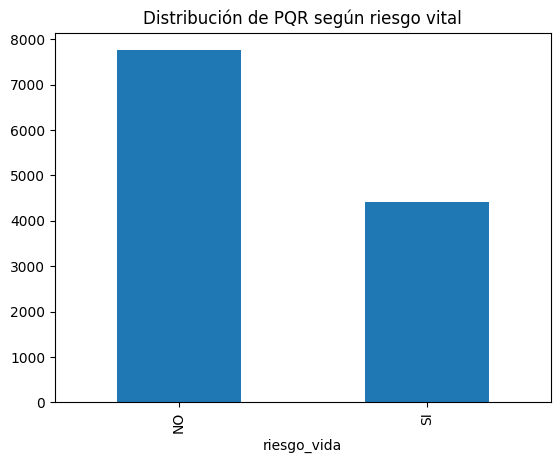

In [ ]:
#Análisis univariado
df_cundinamarca["riesgo_vida"].value_counts().plot(kind="bar")
plt.title("Distribución de PQR según riesgo vital")
plt.show()

<Axes: title={'center': 'Distribución por rango de edad afectado'}, ylabel='count'>

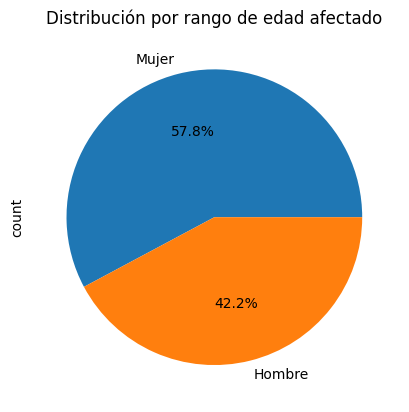

In [ ]:
df_cundinamarca["genero_afectado"].describe()
df_cundinamarca["genero_afectado"].value_counts().plot(
    kind="pie", autopct="%1.1f%%", title="Distribución por rango de edad afectado"
)

<Axes: title={'center': 'Top 10 PQR según el canal'}, ylabel='canal_pqr'>

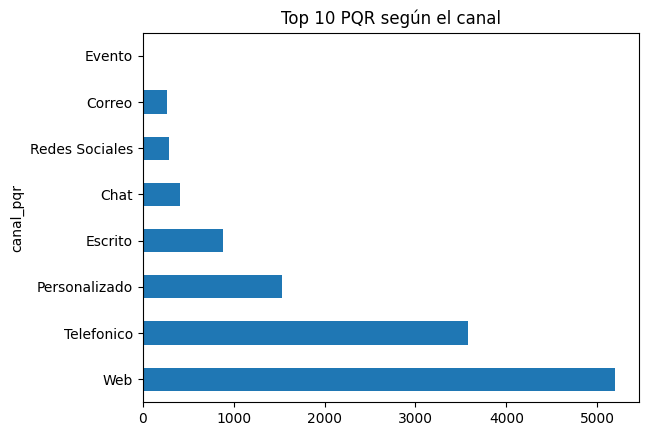

In [ ]:
df_cundinamarca["canal_pqr"].value_counts().head(10).plot(
    kind="barh", title="Top 10 PQR según el canal"
)

In [ ]:
#Se filtraron únicamente los registros correspondientes a enfermedades crónicas no transmisibles, dado que estas requieren tratamiento farmacológico continuo y presentan mayor impacto en el riesgo vital.
patologias_ecnt = [
    "DIABETES",
    "HTA (HIPERTENSION ARTERIAL)",
    "EPOC (ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, BRONQUITIS CRONICA O ENFISEMA)",
    "ENFERMEDAD ISQUMICA CORONARIA",
    "ICC (INSUFICIENCIA CARDIACA CONGESTIVA)",
    "IRC, ENFERMEDAD RENAL",
    "IRC, TRASPLANTE",
    "OBESIDAD",
    "SOBREPESO",
    "ACV (ACCIDENTE CEREBRO VASCULAR)",
    "ENFERMEDAD CARDIOVASCULAR QUE REQUIERA CIRUGIA"
]
df_cundinamarca = df[
    df["patologia_tipo"].isin(patologias_ecnt)
].copy()



In [ ]:
df_cundinamarca["patologia_tipo"].value_counts(normalize=True) * 100

,proportion
patologia_tipo,
HTA (HIPERTENSION ARTERIAL),49.434054
DIABETES,29.753535
"EPOC (ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, BRONQUITIS CRONICA O ENFISEMA)",7.366792
"IRC, ENFERMEDAD RENAL",4.045764
ACV (ACCIDENTE CEREBRO VASCULAR),3.542928
OBESIDAD,2.444288
ICC (INSUFICIENCIA CARDIACA CONGESTIVA),1.553975
"IRC, TRASPLANTE",1.316468
ENFERMEDAD CARDIOVASCULAR QUE REQUIERA CIRUGIA,0.460764


<Axes: title={'center': 'Top 10 de patologías'}, ylabel='patologia_tipo'>

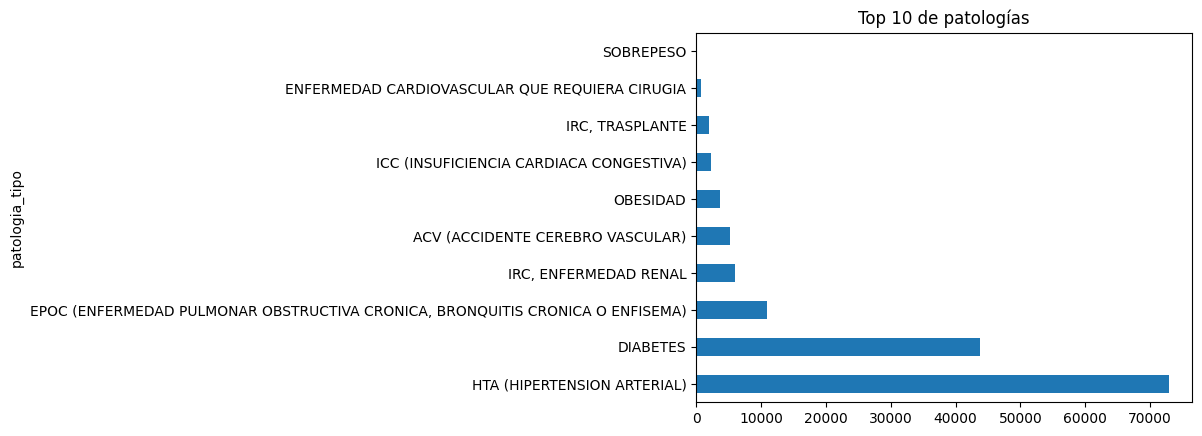

In [ ]:
df_cundinamarca["patologia_tipo"].value_counts().head(10).plot(
    kind='barh', title="Top 10 de patologías"
)

In [ ]:
df_cundinamarca['motivo_especifico'].value_counts()


,count
motivo_especifico,
FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAMENTOS POS,77728
FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAMENTOS NO POS,27744
DEMORA DE LA AUTORIZACION DE MEDICAMENTOS NO-POS,10598
DEMORA DE LA AUTORIZACION DE MEDICAMENTOS POS,10207
DEMORA DE LA AUTORIZACION DE INSUMOS NO-POS,5901
DEMORA DE LA AUTORIZACION DE INSUMOS POS,4770
FALTA DE OPORTUNIDAD POR FRACCIONAMIENTO O ENTREGA INCOMPLETA DE LOS MEDICAMENTOS,2495
NEGACION PARA LA ENTREGA DE MEDICAMENTOS POS,1729
NEGACION PARA LA ENTREGA DE MEDICAMENTOS NO POS,1213


In [ ]:
#Se identificaron los motivos específicos asociados a fallas en la entrega y autorización de medicamentos, los cuales fueron utilizados para construir la variable objetivo.
motivos_falla_medicamentos = [
    'FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAMENTOS POS',
    'FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAMENTOS NO POS',
    'DEMORA DE LA AUTORIZACION DE MEDICAMENTOS POS',
    'DEMORA DE LA AUTORIZACION DE MEDICAMENTOS NO-POS',
    'FALTA DE OPORTUNIDAD POR FRACCIONAMIENTO O ENTREGA INCOMPLETA DE LOS MEDICAMENTOS',
    'NEGACION PARA LA ENTREGA DE MEDICAMENTOS POS',
    'NEGACION PARA LA ENTREGA DE MEDICAMENTOS NO POS',
    'NEGACION DE LA AUTORIZACION DE MEDICAMENTOS POS',
    'NEGACION DE LA AUTORIZACION DE MEDICAMENTOS NO-POS',
    'DEMORA DE LA AUTORIZACION DE MEDICAMENTOS NO-POS PARA ENFERMEDADES RARAS O HUERFANAS',
    'FALTA DE CONTRATACION PARA LA ENTREGA OPORTUNA Y CONTINUA DE MEDICAMENTOS DE ALTO COSTO'
]


In [ ]:
df_cundinamarca = df_cundinamarca[
    df_cundinamarca["motivo_especifico"].isin(motivos_falla_medicamentos)
].copy()


In [ ]:
df_cundinamarca['motivo_especifico'].value_counts()

,count
motivo_especifico,
FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAMENTOS POS,77728
FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAMENTOS NO POS,27744
DEMORA DE LA AUTORIZACION DE MEDICAMENTOS NO-POS,10598
DEMORA DE LA AUTORIZACION DE MEDICAMENTOS POS,10207
FALTA DE OPORTUNIDAD POR FRACCIONAMIENTO O ENTREGA INCOMPLETA DE LOS MEDICAMENTOS,2495
NEGACION PARA LA ENTREGA DE MEDICAMENTOS POS,1729
NEGACION PARA LA ENTREGA DE MEDICAMENTOS NO POS,1213
NEGACION DE LA AUTORIZACION DE MEDICAMENTOS POS,493
FALTA DE CONTRATACION PARA LA ENTREGA OPORTUNA Y CONTINUA DE MEDICAMENTOS DE ALTO COSTO,360


In [ ]:
def clasificar_tipo_falla(motivo):
    if "FALTA DE OPORTUNIDAD" in motivo or "FRACCIONAMIENTO" in motivo:
        return "Falta de oportunidad en entrega"
    if "FRACCIONAMIENTO" in motivo:
        return "Falta de meidcamentos y entrega incompleta"
    elif "DEMORA DE LA AUTORIZACION" in motivo:
        return "Demora en autorización"
    elif "NEGACION DE LA AUTORIZACION" in motivo:
        return "Negación de autorización"
    elif "NEGACION PARA LA ENTREGA" in motivo:
        return "Negación de entrega"
    elif "ALTO COSTO" in motivo or "RARAS O HUERFANAS" in motivo:
        return "Alto costo"
    else:
        return "Otro"


df_cundinamarca["tipo_falla"] = df_cundinamarca["motivo_especifico"].apply(clasificar_tipo_falla)



In [ ]:
df_cundinamarca['tipo_falla'].value_counts()

,count
tipo_falla,
Falta de oportunidad en entrega,107967
Demora en autorización,20814
Negación de entrega,2942
Negación de autorización,787
Alto costo,360


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

df_cundinamarca.to_csv(
    "/content/drive/MyDrive/Analitica/base_cundinamarca.csv",
    index=False
)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Comparación entre grupos relevantes**

In [ ]:
#Se convierte a binaria la variable de riesgo vital y se almacena en una nueva variable llamada riesgo_bin
df_cundinamarca["riesgo_bin"] = df_cundinamarca["riesgo_vida"].map({"SI":1, "NO":0})

In [ ]:
#probabilidad relativa de riesgo por rango de edades.
pd.crosstab(df_cundinamarca["rango_edad_afectado"], df_cundinamarca["riesgo_bin"], normalize="index") * 100

riesgo_bin,0,1
rango_edad_afectado,,
DE 0 A 5,16.230366,83.769634
DE 13 A 17,18.290598,81.709402
DE 18 A 24,42.509506,57.490494
DE 25 A 29,39.768683,60.231317
DE 30 A 37,47.404130,52.595870
DE 38 A 49,52.544208,47.455792
DE 50 A 62,54.722465,45.277535
DE 6 A 12,16.560510,83.439490
MAYOR DE 63,51.500176,48.499824


In [ ]:
#probabilidad relativa de riesgo por el tipo de patología
pd.crosstab(df_cundinamarca["patologia_tipo"], df_cundinamarca["riesgo_bin"], normalize="index") * 100

riesgo_bin,0,1
patologia_tipo,,
ACV (ACCIDENTE CEREBRO VASCULAR),28.435266,71.564734
DIABETES,41.556460,58.443540
ENFERMEDAD CARDIOVASCULAR QUE REQUIERA CIRUGIA,23.762376,76.237624
"EPOC (ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, BRONQUITIS CRONICA O ENFISEMA)",40.901389,59.098611
HTA (HIPERTENSION ARTERIAL),64.123343,35.876657
ICC (INSUFICIENCIA CARDIACA CONGESTIVA),15.884812,84.115188
"IRC, ENFERMEDAD RENAL",19.840031,80.159969
"IRC, TRASPLANTE",1.468189,98.531811
OBESIDAD,78.375149,21.624851


In [ ]:
#probabilidad relativa de riesgo por el motivo específico.
pd.crosstab(df_cundinamarca["tipo_falla"], df_cundinamarca["riesgo_bin"], normalize="index") * 100

riesgo_bin,0,1
tipo_falla,,
Alto costo,38.333333,61.666667
Demora en autorización,46.531181,53.468819
Falta de oportunidad en entrega,52.789278,47.210722
Negación de autorización,49.174079,50.825921
Negación de entrega,50.985724,49.014276


In [ ]:
#probabilidad relativa de riesgo por canal pqr.
pd.crosstab(df_cundinamarca["canal_pqr"], df_cundinamarca["riesgo_bin"], normalize="index") * 100

riesgo_bin,0,1
canal_pqr,,
Chat,48.069241,51.930759
Correo,65.441176,34.558824
Escrito,63.777024,36.222976
Evento,6.140351,93.859649
Medios de comunicacion,25.000000,75.000000
Personalizado,53.328558,46.671442
Redes Sociales,0.387020,99.612980
Telefonico,50.124884,49.875116
Web,57.816690,42.183310


In [ ]:
#probabilidad relativa de riesgo por régimen afectado
pd.crosstab(df_cundinamarca["regimen_afiliacion_afectado"], df_cundinamarca["riesgo_bin"], normalize="index") * 100

riesgo_bin,0,1
regimen_afiliacion_afectado,,
Contributivo,52.598134,47.401866
No Aplica,57.534247,42.465753
PNA,17.647059,82.352941
Particular,55.555556,44.444444
Regimen Especial,58.672892,41.327108
Subsidiado,49.248011,50.751989


In [ ]:
#Análisis estadístico de las variables predictoras o de mayor importancia
variables_categoricas = [
    "motivo_especifico",
    "rango_edad_afectado",
    "patologia_tipo",
    "tipo_falla",
    "canal_pqr",
    "regimen_afiliacion_afectado"
]

resumen_global = []

for var in variables_categoricas:
    resumen_global.append({
        "Variable": var,
        "Total_observaciones": df_cundinamarca[var].notna().sum(),
        "Categorias": df_cundinamarca[var].nunique(),
        "Moda": df_cundinamarca[var].mode().iloc[0]
    })

resumen_global_df = pd.DataFrame(resumen_global)
resumen_global_df


,Variable,Total_observaciones,Categorias,Moda
0,motivo_especifico,132870,11,FALTA DE OPORTUNIDAD EN LA ENTREGA DE MEDICAME...
1,rango_edad_afectado,132870,9,MAYOR DE 63
2,patologia_tipo,132870,10,HTA (HIPERTENSION ARTERIAL)
3,tipo_falla,132870,5,Falta de oportunidad en entrega
4,canal_pqr,132870,9,Telefonico
5,regimen_afiliacion_afectado,132870,6,Contributivo


**Análisis predictivo básico**


In [ ]:
#Variables predictoras
variables = [
    "patologia_tipo",
    "tipo_falla",
    "canal_pqr",
    "rango_edad_afectado",
    "regimen_afiliacion_afectado"
]

df_modelo = df_cundinamarca[variables + ["riesgo_bin"]].dropna()
df_modelo = pd.get_dummies(df_modelo, drop_first=True)

**Modelo predictivo simple**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = df_modelo.drop("riesgo_bin", axis=1)
y = df_modelo["riesgo_bin"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

modelo = LogisticRegression(max_iter=1000)
modelo.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [ ]:
pd.DataFrame({
    "variable": X.columns,
    "coeficiente": modelo.coef_[0]
}).sort_values("coeficiente", ascending=False)

,variable,coeficiente
18,canal_pqr_Redes Sociales,5.511935
6,"patologia_tipo_IRC, TRASPLANTE",3.334109
15,canal_pqr_Evento,2.311154
27,rango_edad_afectado_DE 6 A 12,0.948012
4,patologia_tipo_ICC (INSUFICIENCIA CARDIACA CON...,0.786995
21,rango_edad_afectado_DE 13 A 17,0.687656
5,"patologia_tipo_IRC, ENFERMEDAD RENAL",0.566175
30,regimen_afiliacion_afectado_PNA,0.445258
1,patologia_tipo_ENFERMEDAD CARDIOVASCULAR QUE R...,0.367772
33,regimen_afiliacion_afectado_Subsidiado,0.100643


Los coeficientes indican asociaciones estadísticas con la probabilidad de riesgo de vida, sin implicar relaciones causales. El modelo se utiliza únicamente como apoyo para la priorización temprana.

Probabilidad y uso responsable

In [ ]:
df_modelo["prob_riesgo_vida"] = modelo.predict_proba(X)[:, 1]
df_modelo["prob_riesgo_vida"].describe()

,prob_riesgo_vida
count,132870.000000
mean,0.482039
std,0.192591
min,0.080223
25%,0.340417
50%,0.416328
75%,0.609920
max,0.999968


In [ ]:
df_modelo[df_modelo["prob_riesgo_vida"] > 0.6].head()

,riesgo_bin,patologia_tipo_DIABETES,patologia_tipo_ENFERMEDAD CARDIOVASCULAR QUE REQUIERA CIRUGIA,"patologia_tipo_EPOC (ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, BRONQUITIS CRONICA O ENFISEMA)",patologia_tipo_HTA (HIPERTENSION ARTERIAL),patologia_tipo_ICC (INSUFICIENCIA CARDIACA CONGESTIVA),"patologia_tipo_IRC, ENFERMEDAD RENAL","patologia_tipo_IRC, TRASPLANTE",patologia_tipo_OBESIDAD,patologia_tipo_SOBREPESO,tipo_falla_Demora en autorización,tipo_falla_Falta de oportunidad en entrega,tipo_falla_Negación de autorización,tipo_falla_Negación de entrega,canal_pqr_Correo,canal_pqr_Escrito,canal_pqr_Evento,canal_pqr_Medios de comunicacion,canal_pqr_Personalizado,canal_pqr_Redes Sociales,canal_pqr_Telefonico,canal_pqr_Web,rango_edad_afectado_DE 13 A 17,rango_edad_afectado_DE 18 A 24,rango_edad_afectado_DE 25 A 29,rango_edad_afectado_DE 30 A 37,rango_edad_afectado_DE 38 A 49,rango_edad_afectado_DE 50 A 62,rango_edad_afectado_DE 6 A 12,rango_edad_afectado_MAYOR DE 63,regimen_afiliacion_afectado_No Aplica,regimen_afiliacion_afectado_PNA,regimen_afiliacion_afectado_Particular,regimen_afiliacion_afectado_Regimen Especial,regimen_afiliacion_afectado_Subsidiado,prob_riesgo_vida
0,1,False,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0.820141
5,1,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,0.601769
12,0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.617484
17,0,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.617484
18,1,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.617484


In [ ]:
# =====================
# Predicciones
# =====================
y_pred = modelo.predict(X_test)
y_prob = modelo.predict_proba(X_test)[:,1]

# =====================
# Métricas
# =====================
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1:", f1)
print("AUC:", auc)

Accuracy: 0.6545244725420838
Precision: 0.6619571511291257
Recall: 0.5903434030467338
F1: 0.6241026340930804
AUC: 0.7119730162660569


In [ ]:
metricas = pd.DataFrame({
    "Metrica": ["Accuracy", "Precision", "Recall", "F1-score", "AUC-ROC"],
    "Valor": [accuracy, precision, recall, f1, auc]
})

metricas


,Metrica,Valor
0,Accuracy,0.654524
1,Precision,0.661957
2,Recall,0.590343
3,F1-score,0.624103
4,AUC-ROC,0.711973


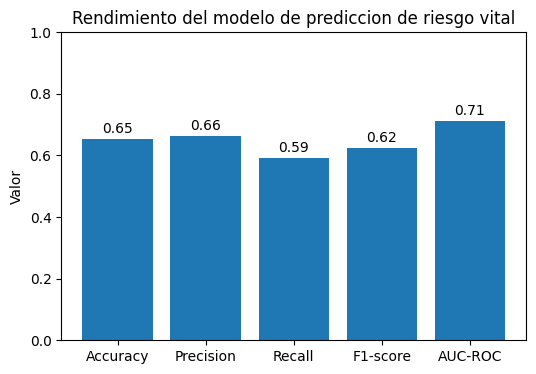

In [ ]:
plt.figure(figsize=(6,4))

bars = plt.bar(metricas["Metrica"], metricas["Valor"])

plt.ylim(0,1)
plt.title("Rendimiento del modelo de prediccion de riesgo vital")
plt.ylabel("Valor")

# mostrar números encima de cada barra
for i, v in enumerate(metricas["Valor"]):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')

plt.show()


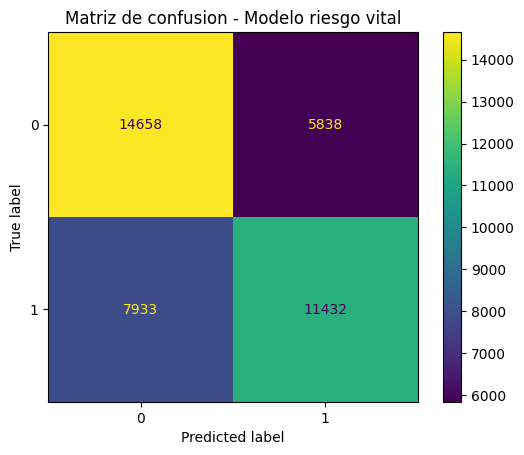

[[14658  5838]
 [ 7933 11432]]


In [ ]:

# matriz
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title("Matriz de confusion - Modelo riesgo vital")
plt.show()

print(cm)
